### Data Loading

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

from processing_utils.feature_data_from_mat import load_subject_high_gamma

Load in S14 Data

In [2]:
S14_hg_trace, S14_hg_map, S14_phon_labels = load_subject_high_gamma('S14', sig_channel=False, zscore=False)

(149, 200, 128)
(149, 8, 16, 200)
(149, 3)


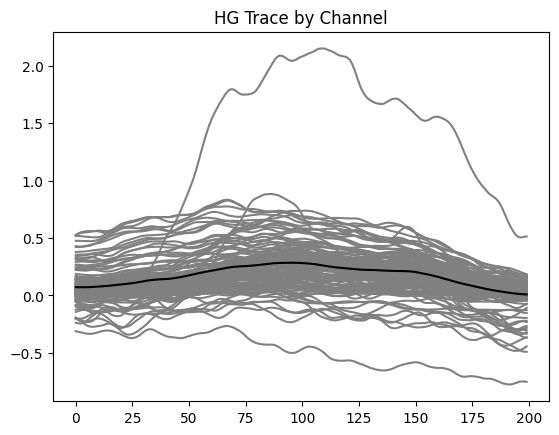

In [3]:
print(S14_hg_trace.shape)
print(S14_hg_map.shape)
print(S14_phon_labels.shape)

plt.figure()
plt.plot(np.mean(S14_hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(S14_hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

Load in S26 Data

In [4]:
S26_hg_trace, S26_hg_map, S26_phon_labels = load_subject_high_gamma('S26', sig_channel=False, zscore=False)

(152, 200, 128)
(152, 8, 16, 200)
(152, 3)


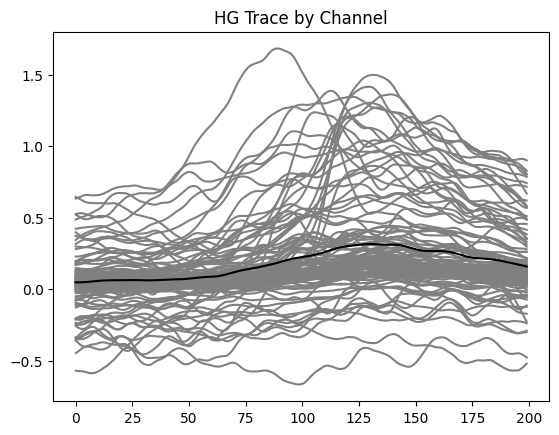

In [5]:
print(S26_hg_trace.shape)
print(S26_hg_map.shape)
print(S26_phon_labels.shape)

plt.figure()
plt.plot(np.mean(S26_hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(S26_hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

Process data for use with 1/3 D CNN Bidirectional LSTM seq2seq

In [6]:
# imports
from processing_utils.sequence_processing import pad_sequence_teacher_forcing

In [7]:
# parameters
n_output = 10

In [8]:
X1 = S14_hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
# X1 = S14_hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X1_prior, y1, prior1_labels, seq1_labels = pad_sequence_teacher_forcing(S14_phon_labels, n_output)  # first 2 outputs one-hot encoded

In [9]:
print(X1.shape, X1_prior.shape, y1.shape, prior1_labels.shape, seq1_labels.shape)

(149, 200, 128) (149, 3, 10) (149, 3, 10) (149, 3) (149, 3)


In [10]:
X2 = S26_hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
# X2 = S26_hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X2_prior, y2, prior2_labels, seq2_labels = pad_sequence_teacher_forcing(S26_phon_labels, n_output)  # first 2 outputs one-hot encoded

In [11]:
print(X2.shape, X2_prior.shape, y2.shape, prior2_labels.shape, seq2_labels.shape)

(152, 200, 128) (152, 3, 10) (152, 3, 10) (152, 3) (152, 3)


Build 1D CNN Bidirectional LSTM seq2seq Model

In [12]:
# imports
from seq2seq_models.rnn_models import lstm_1Dcnn_model

In [18]:
# parameters

# 1D CNN
n_input_time = X1.shape[1]
n_input_channel = X1.shape[2]
filter_size = 10

# 3D CNN
# n_input_channel = [X.shape[1], X.shape[2]]
# n_input_time = X.shape[3]
# filter_size = 2

n_filters = 100
n_units = 800
reg_lambda = 1e-6
bidir = True

In [19]:
train_model, inf_enc, inf_dec = lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)

In [20]:
print(train_model.summary())
print(train_model.layers[-1].summary())
print(inf_enc.summary())
print(inf_enc.layers[-1].summary())
print(inf_dec.summary())

Model: "training_lstm_final"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 200, 128)]   0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 20, 100)      128100      ['input_7[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(None, None, 10)]   0           []                               
                                                                                                  
 training_lstm_initial (Functio  (None, None, 10)    8369610     ['conv1d_1[0][0]',               
 nal)                                                             'input_8[0][0]

### S26 Evaluation

In [21]:
import time
from keras.optimizers import Adam
from train.train import train_seq2seq_kfold

In [25]:
# parameters
num_folds = 10
num_reps = 1
batch_size = 200
epochs = 500
learning_rate = 5e-6

In [26]:
train_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
start = time.time()
histories, y_pred_all, y_test_all = train_seq2seq_kfold(train_model, inf_enc, inf_dec, X2, X2_prior, y2,
                                                        num_folds=num_folds, num_reps=num_reps,
                                                        batch_size=batch_size, epochs=epochs,
                                                        early_stop=False)
end = time.time()

===== Fold 1 =====
Epoch 1/500
1/1 [==============================] - 6s 6s/step - loss: 2.3033 - accuracy: 0.1225 - val_loss: 2.2994 - val_accuracy: 0.0417
Epoch 2/500
1/1 [==============================] - 2s 2s/step - loss: 2.3010 - accuracy: 0.1225 - val_loss: 2.2984 - val_accuracy: 0.0417
Epoch 3/500
1/1 [==============================] - 3s 3s/step - loss: 2.2987 - accuracy: 0.1201 - val_loss: 2.2975 - val_accuracy: 0.0417
Epoch 4/500
1/1 [==============================] - 7s 7s/step - loss: 2.2965 - accuracy: 0.1201 - val_loss: 2.2965 - val_accuracy: 0.0417
Epoch 5/500
1/1 [==============================] - 0s 87ms/step - loss: 2.2943 - accuracy: 0.1176 - val_loss: 2.2956 - val_accuracy: 0.0417
Epoch 6/500
1/1 [==============================] - 0s 102ms/step - loss: 2.2921 - accuracy: 0.1152 - val_loss: 2.2947 - val_accuracy: 0.0417
Epoch 7/500
1/1 [==============================] - 1s 1s/step - loss: 2.2899 - accuracy: 0.1176 - val_loss: 2.2938 - val_accuracy: 0.0417
Epoch 8/50

In [28]:
print(f'Time to train {num_folds} folds: {end-start} seconds')

Time to train 10 folds: 2369.9515132904053 seconds


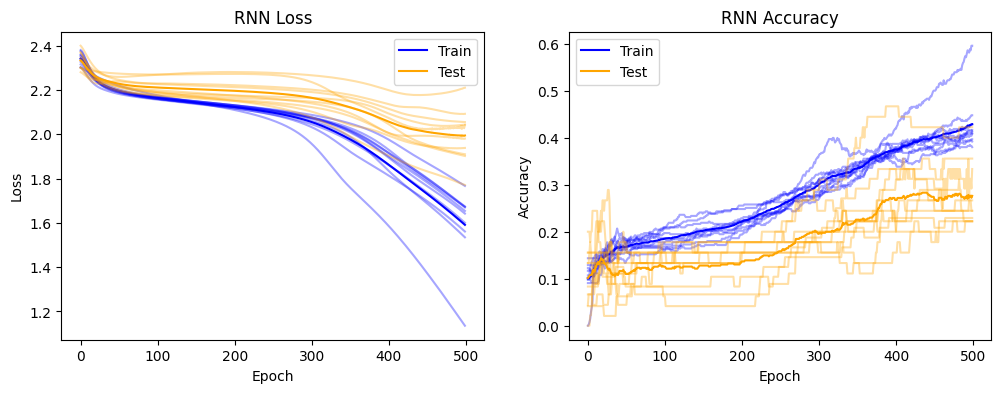

In [29]:
from visualization.plot_model_performance import extend_history_lists

histories = extend_history_lists(histories, epochs=epochs)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.array(histories['loss']).T, color='blue', alpha=0.35)
ax1.plot(np.mean(histories['loss'], axis=0), color='blue', label='Train')
ax1.plot(np.array(histories['val_loss']).T, color='orange', alpha=0.35)
ax1.plot(np.mean(histories['val_loss'], axis=0), color='orange', label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(np.array(histories['accuracy']).T, color='blue', alpha=0.35)
ax2.plot(np.mean(histories['accuracy'], axis=0), color='blue', label='Train')
ax2.plot(np.array(histories['val_accuracy']).T, color='orange', alpha=0.35)
ax2.plot(np.mean(histories['val_accuracy'], axis=0), color='orange', label='Test')
# ax2.axhline(1/(n_output-1), color='gray', linestyle='--', label='Chance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()

plt.show()

In [30]:
from sklearn.metrics import balanced_accuracy_score

print(f'Balanced Accuracy: {balanced_accuracy_score(y_test_all, y_pred_all)}')

Balanced Accuracy: 0.25095426833394924


In [38]:
from visualization.plot_model_performance import plot_accuracy_loss

plot_accuracy_loss(histories, epochs=epochs)

ValueError: List length is greater than specified length.

### Transfer Training S14 -> S26

In [31]:
# imports
from keras.optimizers import Adam
from train.transfer_training import transfer_seq2seq_kfold

In [32]:
trans_model, trans_enc, trans_dec = lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)

In [33]:
# parameters
num_folds = 10
batch_size = 200
# epochs = 500
learning_rate = 5e-6

trans_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
models, histories, y_pred_all, y_test_all = transfer_seq2seq_kfold(trans_model, trans_enc, trans_dec, X1, X1_prior, y1, X2, X2_prior, y2, num_folds=num_folds)

========== Fold 1 ==========
Epoch 1/200
1/1 [==============================] - 0s 245ms/step - loss: 2.3075 - accuracy: 0.1387
Epoch 2/200
1/1 [==============================] - 0s 451ms/step - loss: 2.3067 - accuracy: 0.1387
Epoch 3/200
1/1 [==============================] - 0s 137ms/step - loss: 2.3056 - accuracy: 0.1387
Epoch 4/200
1/1 [==============================] - 0s 63ms/step - loss: 2.3041 - accuracy: 0.1387
Epoch 5/200
1/1 [==============================] - 0s 133ms/step - loss: 2.3025 - accuracy: 0.1387
Epoch 6/200
1/1 [==============================] - 0s 248ms/step - loss: 2.3008 - accuracy: 0.1387
Epoch 7/200
1/1 [==============================] - 0s 248ms/step - loss: 2.2989 - accuracy: 0.1387
Epoch 8/200
1/1 [==============================] - 0s 164ms/step - loss: 2.2970 - accuracy: 0.1387
Epoch 9/200
1/1 [==============================] - 0s 67ms/step - loss: 2.2950 - accuracy: 0.1387
Epoch 10/200
1/1 [==============================] - 0s 80ms/step - loss: 2.2929 - 

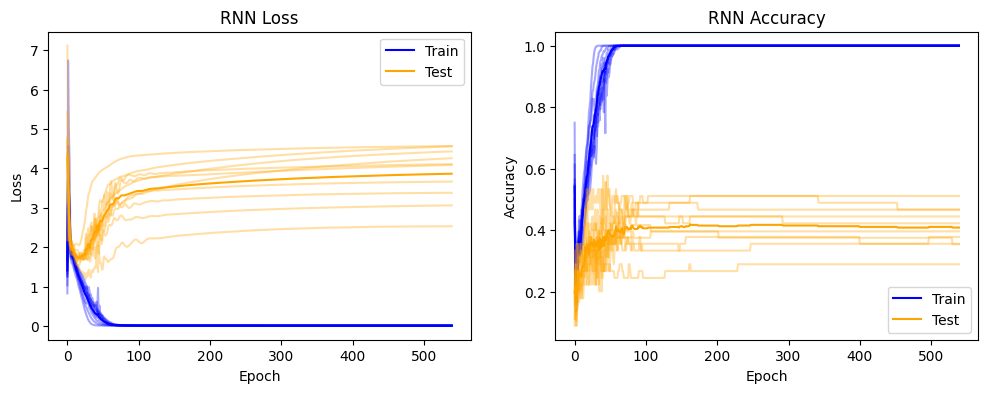

In [36]:
# from visualization.plot_model_performance import extend_history_lists

# histories = extend_history_lists(histories, epochs=epochs)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.array(histories['loss']).T, color='blue', alpha=0.35)
ax1.plot(np.mean(histories['loss'], axis=0), color='blue', label='Train')
ax1.plot(np.array(histories['val_loss']).T, color='orange', alpha=0.35)
ax1.plot(np.mean(histories['val_loss'], axis=0), color='orange', label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(np.array(histories['accuracy']).T, color='blue', alpha=0.35)
ax2.plot(np.mean(histories['accuracy'], axis=0), color='blue', label='Train')
ax2.plot(np.array(histories['val_accuracy']).T, color='orange', alpha=0.35)
ax2.plot(np.mean(histories['val_accuracy'], axis=0), color='orange', label='Test')
# ax2.axhline(1/(n_output-1), color='gray', linestyle='--', label='Chance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()

plt.show()

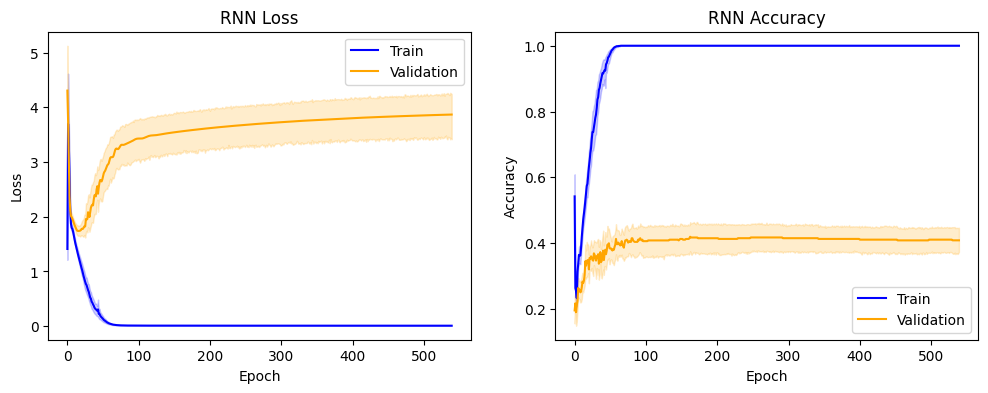

In [39]:
from visualization.plot_model_performance import plot_accuracy_loss

plot_accuracy_loss(histories, epochs=540)

In [37]:
from sklearn.metrics import balanced_accuracy_score

print('Balanced Accuracy: ', balanced_accuracy_score(y_test_all, y_pred_all))

Balanced Accuracy:  0.36546767902142296


### Transfer Training S26 -> S14

In [1]:
# imports
from keras.optimizers import Adam
from train.transfer_training import transfer_seq2seq_kfold

In [18]:
trans_model, trans_enc, trans_dec = lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)

In [19]:
# parameters
num_folds = 5
batch_size = 200
# epochs = 500
learning_rate = 5e-6

trans_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
models2, histories2, y_pred2_all, y_test2_all = transfer_seq2seq_kfold(trans_model, trans_enc, trans_dec, X2, X2_prior, y2, X1, X1_prior, y1, num_folds=num_folds)

========== Fold 1 ==========
Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 2.3893 - accuracy: 0.1031
Epoch 2/200
1/1 [==============================] - 1s 589ms/step - loss: 2.2107 - accuracy: 0.1645
Epoch 3/200
1/1 [==============================] - 1s 552ms/step - loss: 2.1666 - accuracy: 0.2061
Epoch 4/200
1/1 [==============================] - 1s 545ms/step - loss: 2.1356 - accuracy: 0.2368
Epoch 5/200
1/1 [==============================] - 1s 547ms/step - loss: 2.1185 - accuracy: 0.2083
Epoch 6/200
1/1 [==============================] - 1s 553ms/step - loss: 2.0901 - accuracy: 0.2368
Epoch 7/200
1/1 [==============================] - 1s 593ms/step - loss: 2.0575 - accuracy: 0.2785
Epoch 8/200
1/1 [==============================] - 1s 620ms/step - loss: 2.0112 - accuracy: 0.3180
Epoch 9/200
1/1 [==============================] - 1s 589ms/step - loss: 1.9599 - accuracy: 0.3114
Epoch 10/200
1/1 [==============================] - 1s 599ms/step - loss: 2.1594 - 

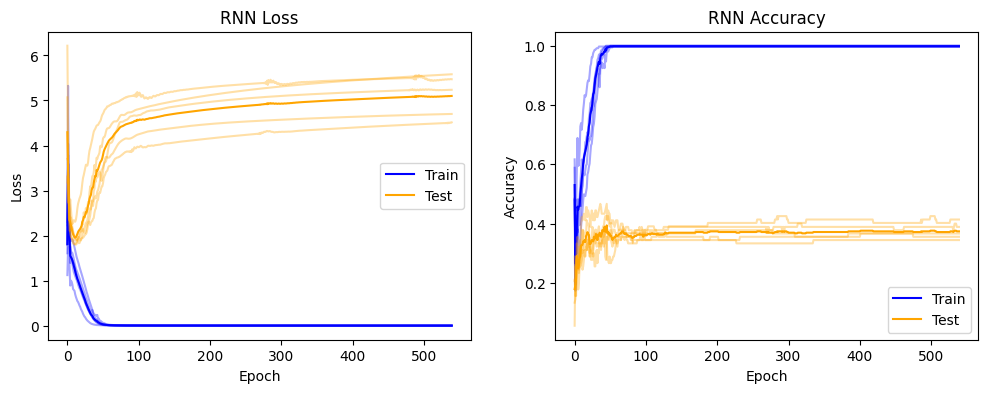

In [21]:
# from visualization.plot_model_performance import extend_history_lists

# histories = extend_history_lists(histories, epochs=epochs)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.array(histories2['loss']).T, color='blue', alpha=0.35)
ax1.plot(np.mean(histories2['loss'], axis=0), color='blue', label='Train')
ax1.plot(np.array(histories2['val_loss']).T, color='orange', alpha=0.35)
ax1.plot(np.mean(histories2['val_loss'], axis=0), color='orange', label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(np.array(histories2['accuracy']).T, color='blue', alpha=0.35)
ax2.plot(np.mean(histories2['accuracy'], axis=0), color='blue', label='Train')
ax2.plot(np.array(histories2['val_accuracy']).T, color='orange', alpha=0.35)
ax2.plot(np.mean(histories2['val_accuracy'], axis=0), color='orange', label='Test')
# ax2.axhline(1/(n_output-1), color='gray', linestyle='--', label='Chance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()

plt.show()

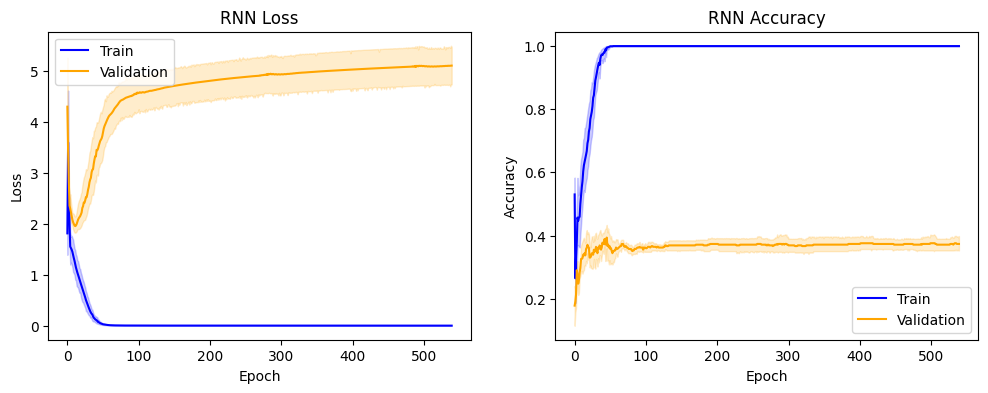

In [23]:
from visualization.plot_model_performance import plot_accuracy_loss

plot_accuracy_loss(histories2, epochs=540)

In [22]:
from sklearn.metrics import balanced_accuracy_score

print('Balanced Accuracy: ', balanced_accuracy_score(y_test2_all, y_pred2_all))

Balanced Accuracy:  0.3387136544909631
